In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [3]:
import numpy as np
import pandas as pd

In [14]:
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 13.4 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
import spacy
import re

nlp = spacy.load("en_core_web_md")

def spacy_clean(text):
    doc = nlp(text.lower())
    cleaned = [
        token.lemma_ for token in doc
        if not token.is_stop and not token.is_punct and not token.like_num
    ]
    return ' '.join(cleaned)

def final_clean(text):
    text = spacy_clean(text)
    text = re.sub(r'\w*\d\w*', '', text)  # remove words with numbers
    return text

In [5]:
drake_df = pd.read_csv("Drake.csv")
taylor_df = pd.read_csv("TaylorSwift.csv")
beyonce_df = pd.read_csv("Beyonce.csv")

beyonce_df['label'] = 'Beyonce'
drake_df['label'] = 'Drake'
taylor_df['label'] = 'Taylor Swift'

sample_size = 300

drake_sample = drake_df[['Lyric']].dropna().sample(n=sample_size, random_state=42)
drake_sample['label'] = 'Drake'

taylor_sample = taylor_df[['Lyric']].dropna().sample(n=sample_size, random_state=42)
taylor_sample['label'] = 'Taylor Swift'

beyonce_sample = beyonce_df[['Lyric']].dropna().sample(n=sample_size, random_state=42)
beyonce_sample['label'] = 'Beyonce'


df = pd.concat([drake_sample, taylor_sample, beyonce_sample], ignore_index=True)
df.dropna(subset=['Lyric'], inplace=True)

# Apply cleaning
df['clean_lyrics'] = df['Lyric'].apply(final_clean)
df[['label', 'clean_lyrics']].sample(5)

,label,clean_lyrics
719,Beyonce,time move fast turn exactly mom dad want ra...
744,Beyonce,brokenhearted girl brokenhearted girl brokenhe...
809,Beyonce,star search excerpt challenger young group hou...
476,Taylor Swift,ribbon bow mean thing song survive golden ring...
739,Beyonce,martin luther king jr architect republic write...


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

le = LabelEncoder()
df['encoded_label'] = le.fit_transform(df['label'])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_lyrics'], df['encoded_label'], stratify=df['encoded_label'], test_size=0.2, random_state=42
)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)
class_names = le.classes_


Logistic Regression Evaluation
Accuracy: 0.8444444444444444
              precision    recall  f1-score   support

     Beyonce       0.80      0.75      0.78        60
       Drake       0.94      0.98      0.96        60
Taylor Swift       0.79      0.80      0.79        60

    accuracy                           0.84       180
   macro avg       0.84      0.84      0.84       180
weighted avg       0.84      0.84      0.84       180



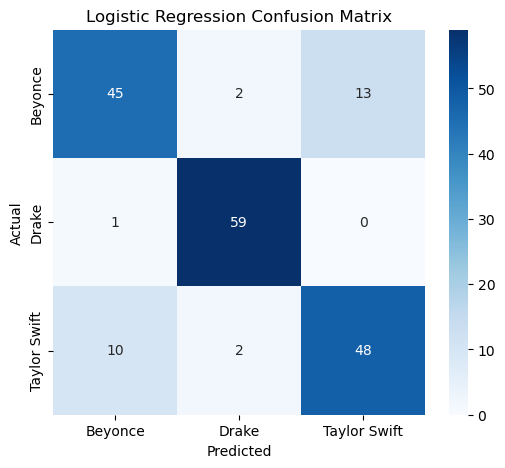

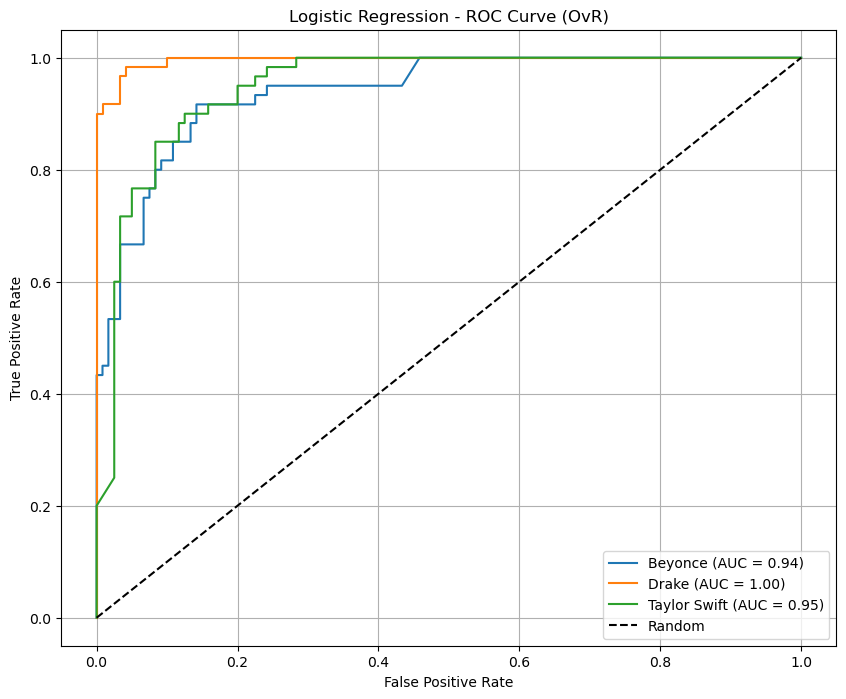


SVM Evaluation
Accuracy: 0.8444444444444444
              precision    recall  f1-score   support

     Beyonce       0.83      0.75      0.79        60
       Drake       0.92      0.97      0.94        60
Taylor Swift       0.78      0.82      0.80        60

    accuracy                           0.84       180
   macro avg       0.84      0.84      0.84       180
weighted avg       0.84      0.84      0.84       180



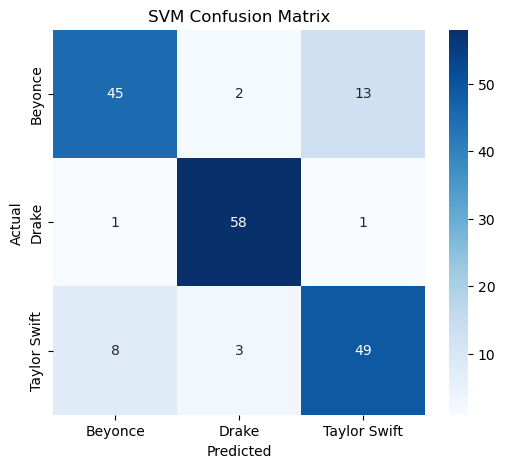

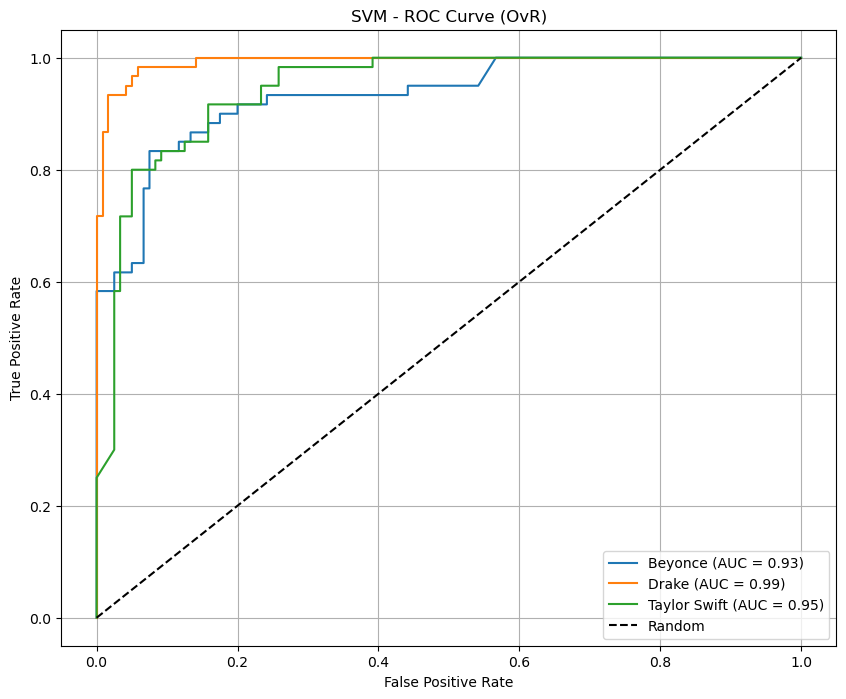


Random Forest Evaluation
Accuracy: 0.8555555555555555
              precision    recall  f1-score   support

     Beyonce       0.87      0.77      0.81        60
       Drake       0.90      0.95      0.93        60
Taylor Swift       0.80      0.85      0.82        60

    accuracy                           0.86       180
   macro avg       0.86      0.86      0.85       180
weighted avg       0.86      0.86      0.85       180



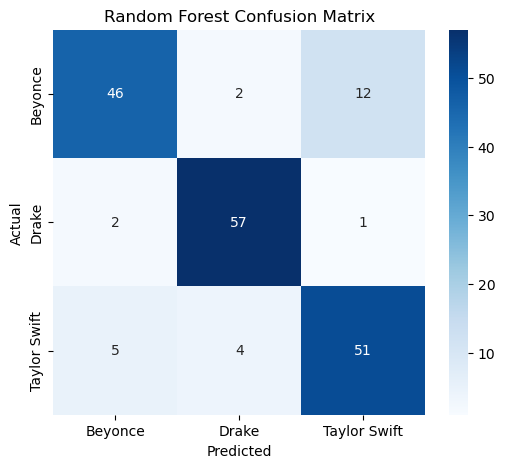

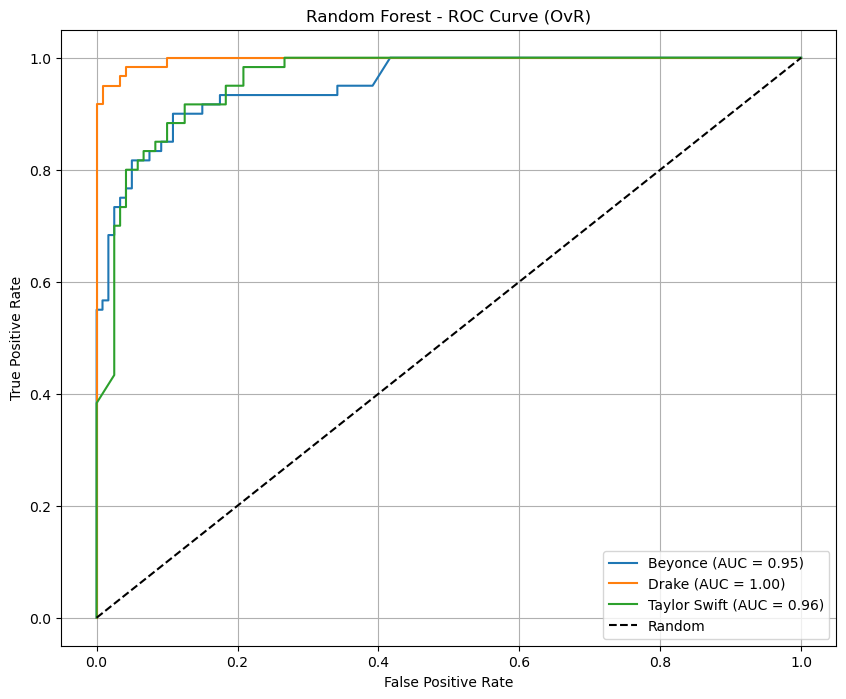


Naive Bayes Evaluation
Accuracy: 0.8222222222222222
              precision    recall  f1-score   support

     Beyonce       0.93      0.65      0.76        60
       Drake       0.82      1.00      0.90        60
Taylor Swift       0.75      0.82      0.78        60

    accuracy                           0.82       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.82      0.82       180



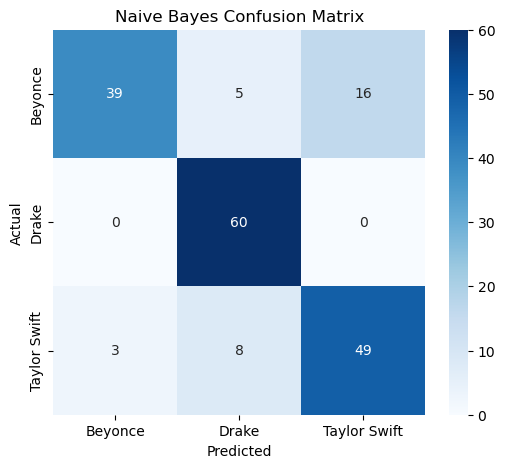

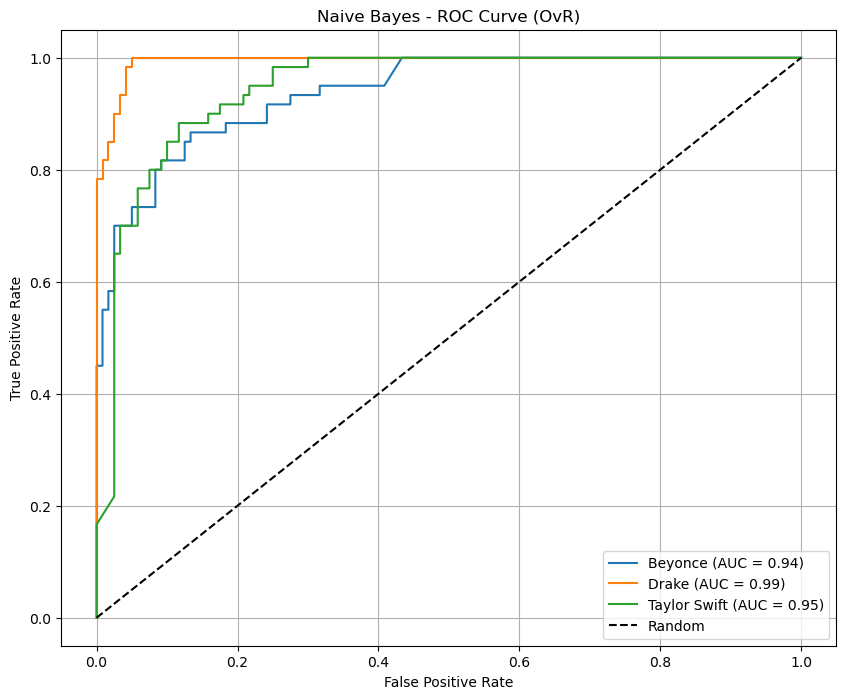

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, RocCurveDisplay
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

tfidf = TfidfVectorizer(max_features=5000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)
class_names = le.classes_

# Updated evaluation function for binary case
def evaluate_model_with_roc(model, name):
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)

    print(f"\n{name} Evaluation")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=class_names))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC curve for multi-class using One-vs-Rest
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    clf = OneVsRestClassifier(model)
    clf.fit(X_train_vec, y_train)
    y_score = clf.predict_proba(X_test_vec)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_test_bin.shape[1]

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} - ROC Curve (OvR)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Evaluate models with full visuals
evaluate_model_with_roc(LogisticRegression(max_iter=1000), "Logistic Regression")
evaluate_model_with_roc(SVC(kernel='linear', probability=True), "SVM")
evaluate_model_with_roc(RandomForestClassifier(n_estimators=100), "Random Forest")
evaluate_model_with_roc(MultinomialNB(), "Naive Bayes")

In [ ]:
# total number
total_records = len(df)
total_records

900

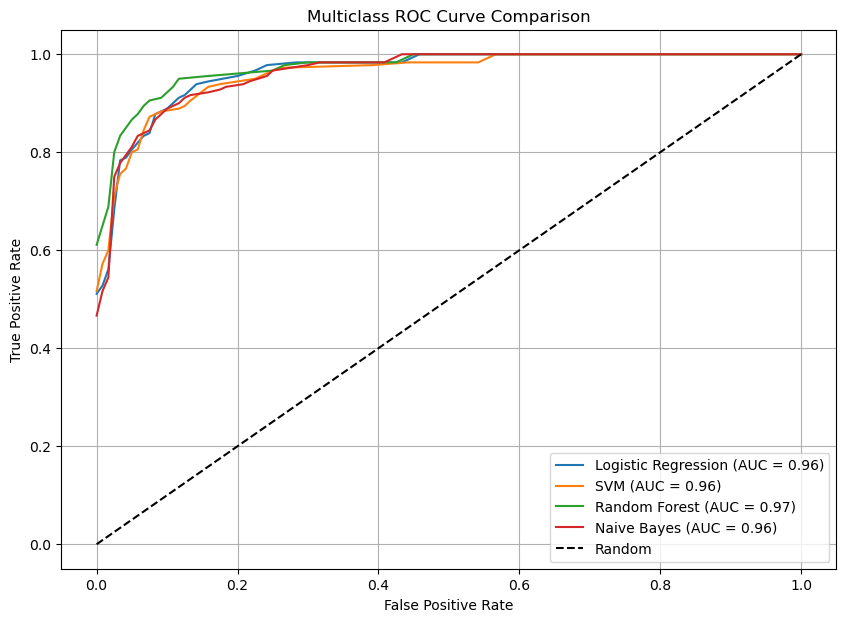

In [10]:
y_test_bin = label_binarize(y_test, classes=range(len(class_names)))

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Naive Bayes": MultinomialNB()
}

# Create one shared ROC plot
plt.figure(figsize=(10, 7))
for name, model in models.items():
    clf = OneVsRestClassifier(model)
    clf.fit(X_train_vec, y_train)
    y_score = clf.predict_proba(X_test_vec)

    # Compute ROC curve and AUC for each class, then average
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Macro-average ROC curve
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(class_names)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(class_names)
    macro_auc = auc(all_fpr, mean_tpr)

    plt.plot(all_fpr, mean_tpr, label=f"{name} (AUC = {macro_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title("Multiclass ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
